# Chapter 3 - Classification

In [1]:
##### Imports

# For the dataset
from sklearn.datasets import fetch_mldata

# For plotting
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

# Import numpy
import numpy as np

# Import classifiers
from sklearn.linear_model import SGDClassifier

# For cross validation
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict

# For the confusion matrix
from sklearn.metrics import confusion_matrix

# For the precision/recall
from sklearn.metrics import precision_score, recall_score

# For the F1 score
from sklearn.metrics import f1_score

# For the precision recall curve
from sklearn.metrics import precision_recall_curve

# For the ROC curve
from sklearn.metrics import roc_curve

# For the ROC score
from sklearn.metrics import roc_auc_score

# The Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# KNN Classifier
from sklearn.neighbors import KNeighborsClassifier

# Scale the inputs
from sklearn.preprocessing import StandardScaler


In [2]:
##### Functions
# Function to plot precision vs thresholds and
#                  recall    vs thresholds
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.xlabel("Threshold")
    plt.legend(loc="upper left")
    plt.ylim([0, 1])
    
# Function to plot precision vs recall
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    
# Function to plot TPR vs FPR
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1],'k--')
    plt.axis([0, 1, 0, 1])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
# Function to plot 2D matrices as images
def plot_matrix(matrix_to_plot):
    plt.matshow(matrix_to_plot, cmap=plt.cm.gray)
    plt.xlabel("Actual")
    plt.ylabel("Predicted")
    
# EXTRA# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // (images_per_row) + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

# Function to plot one digit    
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")

# Function to plot example digits
def plot_example_digits(X_aa, X_ab, X_ba, X_bb):
    plt.figure(figsize=(8,8))
    plt.subplot(221); plot_digits(X_aa[:25], images_per_row=5);
    plt.subplot(222); plot_digits(X_ab[:25], images_per_row=5);
    plt.subplot(223); plot_digits(X_ba[:25], images_per_row=5);
    plt.subplot(224); plot_digits(X_bb[:25], images_per_row=5);


## 1. Get the MNIST dataset

In [3]:
# Get the dataset
mnist = fetch_mldata('MNIST original')

# It is a dictionary of 4 keys
mnist

{'COL_NAMES': ['label', 'data'],
 'DESCR': 'mldata.org dataset: mnist-original',
 'data': array([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ..., 
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
 'target': array([ 0.,  0.,  0., ...,  9.,  9.,  9.])}

In [4]:
# Look at the shape of the data
X,y = mnist["data"], mnist["target"]
X.shape

(70000, 784)

### Look at a digit

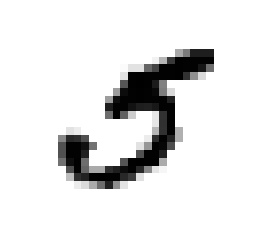

5.0

In [5]:
# Choose a digit
some_idx = 36000
some_digit = X[some_idx]

# Plot digit
plot_digit(some_digit)
plt.show()
y[some_idx]

### The train-test split already exists in the dataset itself

In [6]:
# First 60,000 are for train
# Last  10,000 are for test
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

In [7]:
# Shuffle the data in the training set to guarantee cross-validation folds

# Permute the indices from 0 59,999
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

## 2. Training a Binary Classifier

In [8]:
# We are training a binary classifier for 5 and not-5
y_train_5 = (y_train == 5)
y_test_5  = (y_test == 5)

### Train a stochastic gradient descent classifier

# Create the SGD classifier object
sgd_clf = SGDClassifier(random_state=42)
# Fit the classifier
sgd_clf.fit(X_train, y_train_5)
# Predict a digit (the one chosen above)
sgd_clf.predict([some_digit])


array([ True], dtype=bool)

### Performance Measures
#### Measuring Accuracy Using Cross-Validation

Doing cross validation gives above 90% accuracy.

However, you can achieve 90% accuracy using a dumb classifier 
that only gives False all the time,
because the dataset is skewed, 
meaning it has about 10% 5s and 90% not-5s.

In [9]:
# Performs cross validation cv-fold (here set to 3) and returns the "accuracy" scores
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([ 0.96365,  0.96685,  0.95055])

### Confusion Matrix

A confusion matrix would count the number of times instances of class A have been classified as class B.

![alt text](confusionmatrix.png "A confusion matrix example")


In [10]:
# Similar to cross_val_score, but it returns the predictions
# The predictions are made on parts of the training data that were not used for training
y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

# The confusion matrix shows
# Each row = actual class | Each column = predicted class
# Each row and each column:
#   1st row: non-5          |  1st column: non-5
#   2nd row:     5          |  2nd column:     5
# Or, in matrix form:
#   !5_ac vs !5_pred (correctly classified =  True Neg) | !5_ac vs 5_pred (wrongly classified   = False Pos)
#    5_ac vs !5_pred (wrongly classified   = Flase Neg) |  5_ac vs 5_pred (correctly classified =  True Pos)
confusion_matrix(y_train_5, y_train_pred)


array([[53407,  1172],
       [ 1207,  4214]])

### Precision and Recall

![alt text](precisionrecall.png "Precision and Recall")

In [11]:
# Precision = TP / (TP + FP)
#           = How many selected items are relevant?
#           = the number of correct positive results 
#             divided by the number of all positive results 
#             returned by the classifier
#           = accuracy of the positive predictions
#           = how many times it was correct (true, correctly classified as true) overall
precision_score(y_train_5, y_train_pred)

0.78239881173412551

In [12]:
# Recall = TP / (TP + FN)
#        = How many relevant items are selected?
#        = the number of correct positive results 
#          divided by the number of all relevant samples 
#          (all samples that should have been identified as positive). 
#        = sensitivity or true positive rate
#        = how many times it detected the correct class vs the missclassified as negative when it was positive
recall_score(y_train_5, y_train_pred)

0.77734735288692125

### The F1 score

#### The F1 score is the harmonic mean of precision and recall

F1 = 2 / (1/Precision + 1/Recall) = 2 * (P * R) / (P + R) = TP / (TP + (FN + FP)/2)

#### The F1 score is the harmonic average of the precision and recall
where an F1 score reaches:
* its best value at 1 (perfect precision and recall) and 
* worst at 0.

#### Harmonic mean
* The harmonic mean is the reciprocal of the arithmetic mean of the reciprocals.
* It is calculated by dividing the number of observations by the reciprocal of each number in the series. 


In [13]:
f1_score(y_train_5, y_train_pred)

0.77986490237808825

### Precision/Recall Tradeoff

In [14]:
# Retrieve the scores of the classifier
# The scores are calculated based on a decision function
# And if the score > threshold it assigns to the positive class
#     if the score < threshold it assigns to the negative class
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method="decision_function")
y_scores

array([ -349664.38649795, -1168729.55597637,  -410106.08023772, ...,
        -368724.13764491,  -441141.6621102 ,  -588606.57487096])

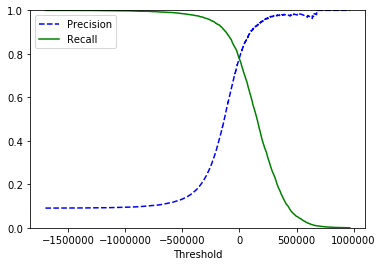

In [15]:
# Calculate the precisions and recalls for every threshold
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

# Plot the precisions and the recalls for every threshold
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)


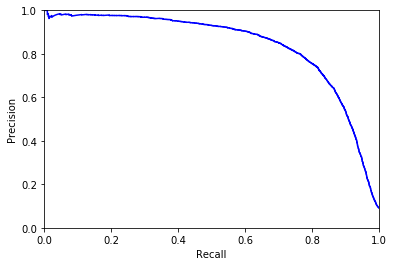

In [16]:
# Plot precision versus recall
plot_precision_vs_recall(precisions, recalls)

In [17]:
y_train_pred_90 = (y_scores > 70000)
precision_score(y_train_5, y_train_pred_90)

0.87308533916849018

In [18]:
recall_score(y_train_5, y_train_pred_90)

0.66242390702822362

### The Receiver Operating Characteristic (ROC) Curve

![alt text](sensitivityspecificity.png "Sensitivity (Recall) and Specificity")

#### The ROC curve plots 
* the  True Positive Rate (Sensitivity) vs 
* the False Positive Rate (1 - Specificity)

#### Observations about ROC Curve:
* Once again there is a tradeoff: the higher the recall (TPR), the more false positives (FPR) the classifier produces. 
* The dotted line represents the ROC curve of a purely random classifier.
* A good classifier stays as far away from that line as possible (toward the top-left corner).

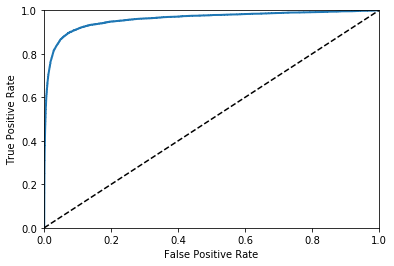

Area under the ROC curve: 0.959966581445


In [19]:
fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

plot_roc_curve(fpr, tpr)
plt.show()

print("Area under the ROC curve:", roc_auc_score(y_train_5, y_scores))

#### Observations about whether to use ROC or PR (precision vs recall):
* As a rule of thumb, you should prefer the PR curve whenever the positive class is rare or when you care more about the false positives than the false negatives, and the ROC curve otherwise. 
* For example, looking at the previous ROC curve (and the ROC AUC score), you may think that the classifier is really good. 
* But this is mostly because there are few positives (5s) compared to the negatives (non-5s). 
* In contrast, the PR curve makes it clear that the classifier has room for improvement (the curve could be closer to the top-right corner).

### Comparison of ROC curves with a Random Forest Classifier


In [20]:
# Create a random forest classifier object
forest_clf = RandomForestClassifier(random_state=42)

# Train it => you get probabilities for each class (60,000 x 2 array)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method="predict_proba")

y_probas_forest.shape

(60000, 2)

In [21]:
# Get scores for the positive class
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class 

# Get the ROC curve for the RFC
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)


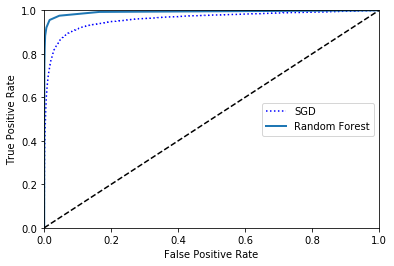

Area under the ROC curve SGD: 0.959966581445
Area under the ROC curve RFC: 0.992514468018


In [22]:
# Plot them together
plt.plot(fpr, tpr, "b:", label="SGD")
plot_roc_curve(fpr_forest, tpr_forest, "Random Forest")
plt.legend(loc="right")
plt.show()

# Areas under the curves:
print("Area under the ROC curve SGD:", roc_auc_score(y_train_5, y_scores))
print("Area under the ROC curve RFC:", roc_auc_score(y_train_5, y_scores_forest))

## 3. Multiclass Classification

Multi-class classification for binary classifiers can be achieved in two ways:
1. __OvA__ = __One vs All__ strategy, where you train A-vs-Rest, B-vs-Rest, etc. and then choose the class with the highest score among all classifiers.
2. __OvO__ = __One vs One__ strategy, where you train A-vs-B, A-vs-C, B-vs-C, etc. and then choose the class with the highest score among all classifiers.
    * Does not scale very well - for N classes you need N x (N - 1) / 2 classifiers

#### The following code does this:
* This code trains the SGDClassifier on the training set using the original target classes from 0 to 9 (y_train), instead of the 5-versus-all target classes (y_train_5). 
* Then it makes a prediction (a correct one in this case). 
* Under the hood, Scikit-Learn actually trained 10 binary classifiers, got their decision scores for the image, and selected the class with the highest score.

In [23]:
# Train on all
sgd_clf.fit(X_train, y_train) # y_train, not y_train_5 

# Predict for some_digit
sgd_clf.predict([some_digit])

array([ 5.])

In [24]:
# Get the scores of the decision functions
some_digit_scores = sgd_clf.decision_function([some_digit])
# Are indeed 10 scores as it trained 10 OvA classifiers
some_digit_scores

array([[-205593.80327707, -462426.54849797, -120717.022808  ,
        -219916.38880543, -356134.26994509,   83574.94034374,
        -669281.64924366, -415723.32887839, -577030.37155644,
        -697053.00551228]])

In [25]:
# Give the class that gives the highest score
np.argmax(some_digit_scores)

5

In [26]:
# Shows the classes in the classifier
sgd_clf.classes_

array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

#### Random forest

In [27]:
# Random Forest classifier - does not use OvA or OvO
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([ 5.])

In [28]:
# The probabilities are stored here:
forest_clf.predict_proba([some_digit])

array([[ 0. ,  0. ,  0. ,  0.1,  0. ,  0.8,  0. ,  0. ,  0. ,  0.1]])

#### Evaluate the two classifiers

##### SGD

In [29]:
# Accuracy Score
cross_val_score(sgd_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.84793041,  0.87324366,  0.82377357])

In [30]:
# Accuracy Score After scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.astype(np.float64))
cross_val_score(sgd_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.90926815,  0.91074554,  0.9073361 ])

##### RFC

In [31]:
# Accuracy Score
cross_val_score(forest_clf, X_train, y_train, cv=3, scoring="accuracy")

array([ 0.94006199,  0.94154708,  0.94204131])

In [32]:
# Accuracy Score After scaling
cross_val_score(forest_clf, X_train_scaled, y_train, cv=3, scoring="accuracy")

array([ 0.93996201,  0.94154708,  0.94214132])

### Error Analysis

1. First, we will look at the confusion matrix of the predictions

In [33]:
# Get the predicted values
y_train_pred = cross_val_predict(sgd_clf, X_train_scaled, y_train, cv=3)
# Calculate the confusion matrix between actual and predicted
conf_mx = confusion_matrix(y_train, y_train_pred)
conf_mx

array([[5737,    2,   20,    9,   10,   44,   49,    8,   39,    5],
       [   1, 6465,   51,   27,    6,   40,    8,   10,  121,   13],
       [  59,   40, 5310,  107,   89,   23,   93,   59,  161,   17],
       [  48,   43,  137, 5342,    3,  232,   36,   53,  133,  104],
       [  19,   29,   26,    9, 5392,    9,   57,   27,   84,  190],
       [  76,   37,   35,  196,   78, 4583,  117,   27,  168,  104],
       [  30,   26,   44,    2,   42,   88, 5635,    5,   46,    0],
       [  22,   21,   69,   37,   63,   11,    5, 5787,   16,  234],
       [  57,  149,   67,  161,   14,  156,   58,   29, 5012,  148],
       [  43,   32,   25,   89,  177,   30,    3,  191,   75, 5284]])

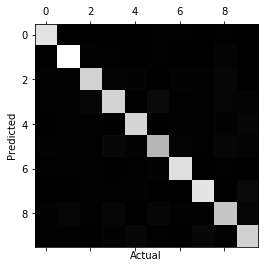

In [34]:
# Plot the confusion matrix
plot_matrix(conf_mx)
plt.show()

We will now focus on the errors, rather than the absolute values.

* Divide each value in the confusion matrix by the number of images in the corresponding class, so you can compare error rates instead of absolute number of errors (which would make abundant classes look unfairly bad)
* Fill the diagonal with zeros to keep only the errors

In [35]:
# Calculate the sum of the predicted
row_sums = conf_mx.sum(axis=1, keepdims=True)
# Normalise confusion matrix by row sums
norm_conf_mx = conf_mx / row_sums 
# Fill the diagonal with zeros
np.fill_diagonal(norm_conf_mx, 0)

#### Observations about the normalised matrix
* Remember that rows represent actual classes, while columns represent predicted classes. 
* The __columns for classes 8 and 9__ are quite bright, which tells you that __many images get misclassified as 8s or 9s__. 
* Similarly, the __rows for classes 8 and 9__ are also quite bright, telling you that __8s and 9s are often confused with other digits__.
* Conversely, some rows are pretty dark, such as row 1: this means that most 1s are classified correctly (a few are confused with 8s, but that’s about it). 
* Notice that the errors are not perfectly symmetrical; for example, there are more 5s misclassified as 8s than the reverse.



* __Analyzing the confusion matrix can often give you insights on ways to improve your classifier.__ 
* __Looking at this plot, it seems that your efforts should be spent on improving classification of 8s and 9s, as well as fixing the specific 3/5 confusion.__

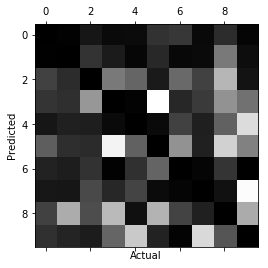

In [36]:
# Plot the normalised matrix
plot_matrix(norm_conf_mx)
plt.show()

#### Let's plot some examples of 3s and 5s

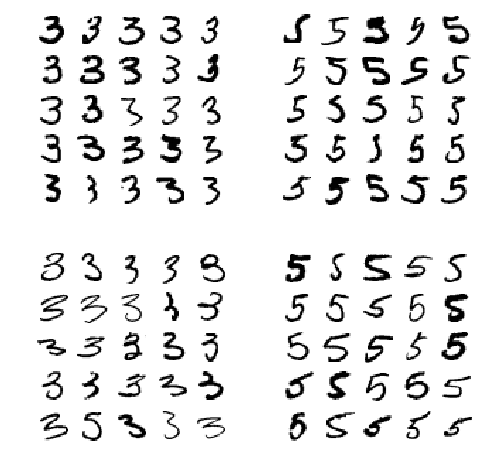

In [37]:
# Classes A and B
cl_a, cl_b = 3, 5
X_aa = X_train[(y_train == cl_a) & (y_train_pred == cl_a)]
X_ab = X_train[(y_train == cl_a) & (y_train_pred == cl_b)]
X_ba = X_train[(y_train == cl_b) & (y_train_pred == cl_a)]
X_bb = X_train[(y_train == cl_b) & (y_train_pred == cl_b)]

# # # PLOT THEM
plot_example_digits(X_aa, X_ba, X_ab, X_bb)
plt.show()


## Multilabel Classification

#### Classification into multiple binary classes

For example, a face recognition system would output [1,0,1] for an image where you can find Alice, cannot find Bob, and can find Charlie.

#### We will use a K nearest neighbours classifier to say if the digits are small or large (>= 7) and if they are odd or even.


In [38]:
# Training labels for big numbers (>=7)
y_train_large = (y_train >= 7)

# Training labels for odd numbers
y_train_odd   = (y_train % 2 == 1)

# Concatenate them 
# np.c_ = Translates slice objects to concatenation along the second axis.
y_multilabel = np.c_[y_train_large, y_train_odd]

y_multilabel

array([[False,  True],
       [False, False],
       [False,  True],
       ..., 
       [ True,  True],
       [False,  True],
       [ True,  True]], dtype=bool)

In [39]:
# Create KNN classifier
knn_clf = KNeighborsClassifier()

# Fit on the training data
knn_clf.fit(X_train, y_multilabel)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [40]:
# Predict the multi-label for the digit 5
knn_clf.predict([some_digit])

array([[False,  True]], dtype=bool)

#### Evaluate the classifier

In [41]:
# Do cross-validation
#y_train_knn_pred = cross_val_predict(knn_clf, X_train, y_train, cv=3)
# Calculate F1 score
#f1_score(y_train, y_train_knn_pred, average="macro")

## Multioutput Classification

* __This is known as a multioutput-multiclass classification.__
* __It is simply a generalization of multilabel classification where each label can be multiclass (i.e., it can have more than two possible values).__

* A good example is to de-noise an image.
* The classifier's output is multilabel (one label per pixel), and each label can have multiple values (from 0 to 255).
* It is, indeed, a blurry line between classification and regression.

In [42]:
# Generate noise for the training and testing sets
noise_train = np.random.randint(0, 100, (len(X_train), 784))
noise_test  = np.random.randint(0, 100, (len(X_test) , 784))

# Add noise to training and testing set
X_train_mod = X_train + noise_train
X_test_mod  = X_test  + noise_test

# The outputs are now the de-noised training and testing sets
y_train_mod = X_train
y_test_mod  = X_test

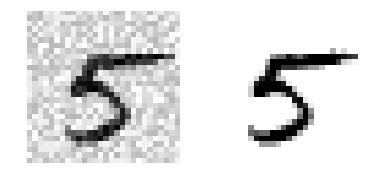

In [43]:
# Have a look at an image
some_index = 5500
plt.subplot(121); plot_digit(X_test_mod[some_index])
plt.subplot(122); plot_digit(y_test_mod[some_index])

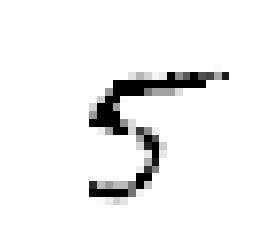

In [44]:
# Fit the KNN classifier
knn_clf.fit(X_train_mod, y_train_mod)
# Predict the de-noised image
clean_digit = knn_clf.predict([X_test_mod[some_index]])
# Plot the de-noised image
plot_digit(clean_digit)
plt.show()
